4/4 [==============================] - 4s 937ms/step


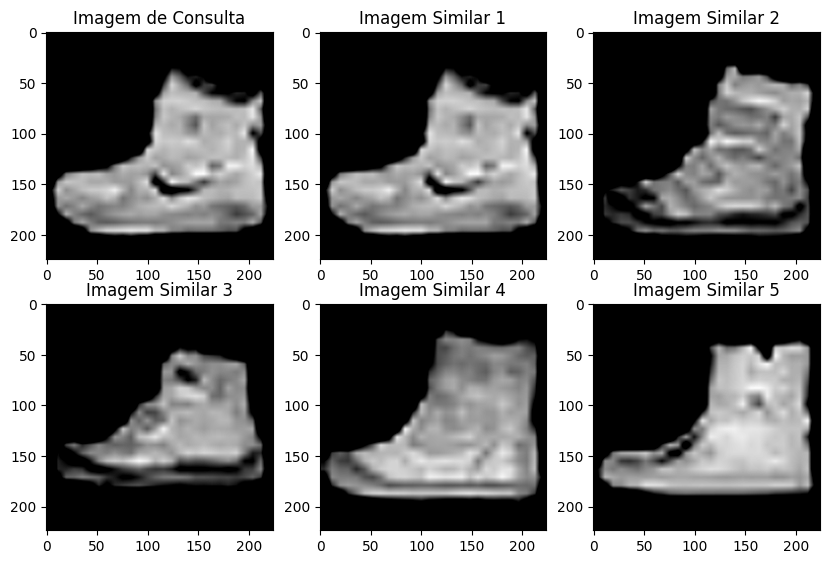

In [1]:
# Instalação das bibliotecas necessárias
!pip install tensorflow opencv-python scikit-learn matplotlib

import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from sklearn.neighbors import NearestNeighbors
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Carregar o conjunto de dados Fashion MNIST
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# As imagens possuem tamanho 28x28, precisamos redimensionar para 224x224 para o modelo MobileNetV2
train_images_resized = np.array([cv2.resize(img, (224, 224)) for img in train_images])
test_images_resized = np.array([cv2.resize(img, (224, 224)) for img in test_images])

# Convertendo de 2D para 3D (RGB) e normalizando
train_images_resized = np.stack([np.repeat(img[:, :, np.newaxis], 3, axis=-1) for img in train_images_resized])
test_images_resized = np.stack([np.repeat(img[:, :, np.newaxis], 3, axis=-1) for img in test_images_resized])

# Pré-processar as imagens para o modelo MobileNetV2
train_images_resized = preprocess_input(train_images_resized)
test_images_resized = preprocess_input(test_images_resized)

# Carregar o modelo MobileNetV2 pré-treinado sem a camada final (classificação)
model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Função para extrair características das imagens usando o modelo MobileNetV2
def extract_features(images):
    return model.predict(images)

# Extrair características das imagens de treinamento e teste (faça isso em lotes para economizar memória)
batch_size = 100  # Ajuste o tamanho do lote se necessário
train_features = []
for i in range(0, len(train_images_resized), batch_size):
    batch = train_images_resized[i:i + batch_size]
    features = extract_features(batch)
    train_features.append(features)

# Converter a lista para um array numpy
train_features = np.vstack(train_features)

# Flatten as características para ficarem em formato vetorial
train_features_flattened = train_features.reshape(train_features.shape[0], -1)

# Configurar o modelo k-NN para encontrar imagens similares
knn = NearestNeighbors(n_neighbors=5, algorithm='ball_tree')
knn.fit(train_features_flattened)

# Função para exibir a imagem de consulta e suas imagens mais semelhantes
def show_similar_images(query_idx):
    distances, indices = knn.kneighbors([train_features_flattened[query_idx]])

    plt.figure(figsize=(10, 10))

    # Imagem de consulta
    plt.subplot(3, 3, 1)
    plt.imshow(train_images_resized[query_idx])
    plt.title('Imagem de Consulta')

    # Imagens semelhantes
    for i, idx in enumerate(indices[0]):
        plt.subplot(3, 3, i+2)
        plt.imshow(train_images_resized[idx])
        plt.title(f'Imagem Similar {i+1}')

    plt.show()

# Escolher uma imagem de exemplo e encontrar as mais semelhantes
query_image_idx = 0  # Alterar o índice para testar com diferentes imagens
show_similar_images(query_image_idx)
